In [56]:
import numpy
import threading
import csv
import pandas as pd
from rpforest import RPForest


data = pd.read_csv('/Users/keke/Downloads/data/iris.data', sep=',').values
data = numpy.ascontiguousarray(data)
labels = data[:,-1]
data =  numpy.ascontiguousarray(data[:,:-1])
data = data.astype('double')


def leaves(predict, leaf):
    treeleaves = predict[0:leaf]
    return treeleaves


def missrateav(n, k, model, data, labels, leaf):
    miss = 0
    for i in range(n):
        count = 0
        predict = model.get_candidates(data[i], number=k, normalise=False)
        treeleaves = leaves(predict, leaf)
        for j in range(leaf):
            if labels[treeleaves[j]] == labels[i]:
                count = count + 1
        if count < k:
            miss = miss + k - count
    return miss / (n*k)


def discrepancyav(n, k, model, data):
    dist = 0
    for i in range(n):
        predict = model.get_candidates(data[i], number=k, normalise=False)
        dist = dist + numpy.linalg.norm(data[i] - data[predict[k-1]])
    return dist / n


def evaluate(data, labels, n, k, t, leaf, steps, runs, avmra, avdia):
    global rc
    for r in range(runs):
        mra = numpy.empty(steps, dtype=float)
        dia = numpy.empty(steps, dtype=float)
        for i in range(steps):
            model = RPForest(leaf_size=leaf, no_trees=t)
            model.fit(data, normalise=False)
            miss = 0
            mra[i] = missrateav(n, k, model, data, labels, leaf)
            dia[i] = discrepancyav(n, k, model, data)
            model.clear()
            if t == 100:
                t = 10
            elif i == 0:
                t = t + 10
            else:
                t = t + 20
        for w in range(steps):
            avmra[w] = avmra[w] + mra[w]
            avdia[w] = avdia[w] + dia[w]
        rc = rc + 1
        if rc == 1:
            print(str(rc) + ' Execution Out of ' + str(run) + ' Completed Successfully!')
        else:
            print(str(rc) + ' Executions Out of ' + str(run) + ' Completed Successfully!')


def normalise(avdia, avdiatemp, steps):
    minim = numpy.min(avdiatemp)
    maxim = numpy.max(avdiatemp)
    for s in range(steps):
        avdia[s] = (avdiatemp[s] - minim) / (maxim - minim)


In [57]:
n = data.shape[0]
k = 5
t = 10
leaf = 20
steps = 6
run = 100
threads = 4
rc = 0
t1avmra = numpy.zeros(steps, dtype=float)
t1avdia = numpy.zeros(steps, dtype=float)
t2avmra = numpy.zeros(steps, dtype=float)
t2avdia = numpy.zeros(steps, dtype=float)
t3avmra = numpy.zeros(steps, dtype=float)
t3avdia = numpy.zeros(steps, dtype=float)
t4avmra = numpy.zeros(steps, dtype=float)
t4avdia = numpy.zeros(steps, dtype=float)
avmra = numpy.zeros(steps, dtype=float)
avdiatemp = numpy.zeros(steps, dtype=float)
avdia = numpy.zeros(steps, dtype=float)

t1 = threading.Thread(target=evaluate, args=(data, labels, n, k, t, leaf, steps, int(run / threads), t1avmra, t1avdia))
t2 = threading.Thread(target=evaluate, args=(data, labels, n, k, t, leaf, steps, int(run / threads), t2avmra, t2avdia))
t3 = threading.Thread(target=evaluate, args=(data, labels, n, k, t, leaf, steps, int(run / threads), t3avmra, t3avdia))
t4 = threading.Thread(target=evaluate, args=(data, labels, n, k, t, leaf, steps, int(run / threads), t4avmra, t4avdia))
t1.start()
t2.start()
t3.start()
t4.start()
t1.join()
t2.join()
t3.join()
t4.join()
for i in range(steps):
    avmra[i] = t1avmra[i] + t2avmra[i] + t3avmra[i] + t4avmra[i]
    avdiatemp[i] = t1avdia[i] + t2avdia[i] + t3avdia[i] + t4avdia[i]
for j in range(steps):
    avmra[j] = avmra[j] / rc
    avdiatemp[j] = avdiatemp[j] / rc
normalise(avdia, avdiatemp, steps)

1 Execution Out of 100 Completed Successfully!
2 Executions Out of 100 Completed Successfully!
3 Executions Out of 100 Completed Successfully!
4 Executions Out of 100 Completed Successfully!
5 Executions Out of 100 Completed Successfully!
6 Executions Out of 100 Completed Successfully!
7 Executions Out of 100 Completed Successfully!
8 Executions Out of 100 Completed Successfully!
9 Executions Out of 100 Completed Successfully!
10 Executions Out of 100 Completed Successfully!
11 Executions Out of 100 Completed Successfully!
12 Executions Out of 100 Completed Successfully!
13 Executions Out of 100 Completed Successfully!
14 Executions Out of 100 Completed Successfully!
15 Executions Out of 100 Completed Successfully!
16 Executions Out of 100 Completed Successfully!
17 Executions Out of 100 Completed Successfully!
18 Executions Out of 100 Completed Successfully!
19 Executions Out of 100 Completed Successfully!
20 Executions Out of 100 Completed Successfully!
21 Executions Out of 100 Compl

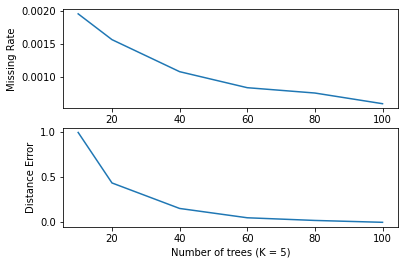

In [58]:
from matplotlib import pyplot as plt 
 
plt.subplot(211)
plt.xlabel("Number of trees (K = 5)") 
plt.ylabel("Missing Rate") 
plt.plot([10,20,40,60,80,100],avmra)

plt.subplot(212)
plt.xlabel("Number of trees (K = 5)") 
plt.ylabel("Distance Error") 
plt.plot([10,20,40,60,80,100],avdia)
plt.show()

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

rpf = RPForest(leaf_size=leaf, no_trees=20)
rpf.fit(X_train)

from collections import Counter

psas = 0
psav = 0
psavc = 0

pvav = 0
pvas = 0
pvavc = 0

pvcas = 0
pvcav = 0
pvcavc = 0

for i in range(len(X_test)):
    neighbors = rpf.query(X_test[i,:], 5)
    n_labels = []
    for n in neighbors:
        n_labels.append(y_train[n]) 
    word_counts = Counter(n_labels)
    label = word_counts.most_common(1)

    if y_test[i] == 'Iris-setosa':
        if label[0][0] == 'Iris-setosa':
            psas += 1
        elif label[0][0] == 'Iris-virginica':
            psav += 1
        elif label[0][0] == 'Iris-versicolor':
            psavc += 1
    elif y_test[i] == 'Iris-virginica':
        if label[0][0] == 'Iris-setosa':
            pvas += 1
        elif label[0][0] == 'Iris-virginica':
            pvav += 1
        elif label[0][0] == 'Iris-versicolor':
            pvavc += 1
    elif y_test[i] == 'Iris-versicolor':
        if label[0][0] == 'Iris-setosa':
            pvcas += 1
        elif label[0][0] == 'Iris-virginica':
            pvcav += 1
        elif label[0][0] == 'Iris-versicolor':
            pvcavc += 1

In [60]:
import prettytable as pt

tb = pt.PrettyTable()
tb.field_names = ["", "Predicted setosa", "Predicted virginica", "Predicted versicolor"]
tb.add_row(["Actual setosa",psas,pvas,pvcas])
tb.add_row(["Actual virginica", psav,pvav,pvcav])
tb.add_row(["Actual versicolor", psavc,pvavc,pvcavc])

print(tb)

+-------------------+------------------+---------------------+----------------------+
|                   | Predicted setosa | Predicted virginica | Predicted versicolor |
+-------------------+------------------+---------------------+----------------------+
|   Actual setosa   |        12        |          0          |          0           |
|  Actual virginica |        0         |          8          |          0           |
| Actual versicolor |        0         |          0          |          10          |
+-------------------+------------------+---------------------+----------------------+


In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

print('Random Forest')
clf = RandomForestClassifier()
clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
# print('Confusion matrix: \n',confusion_matrix(y_test, y_pred, labels=None, sample_weight=None))
# print('Accuracy: ',accuracy_score(y_test, y_pred))
# print('Precision: ',precision_score(y_test, y_pred))
# print('Recall: ',recall_score(y_test, y_pred))
# print('F1 measure: ',f1_score(y_test, y_pred))


Random Forest


In [63]:
print('Confusion matrix: \n',confusion_matrix(y_test, y_pred, labels=None, sample_weight=None))

Confusion matrix: 
 [[12  0  0]
 [ 0 10  0]
 [ 0  3  5]]
